# Logistic Regression: Predicting Win Probability

This notebook uses a scikit-learn logistic regression model to predict whether the home team will win a college football game. It serves as a fast, interpretable baseline for model evaluation.

**Logistic regression** is a statistical method used for binary classification problems, where the outcome is a binary variable (e.g., win or lose). It models the probability that a given input point belongs to a certain class. The key difference between logistic regression and linear regression is that linear regression predicts a continuous output, while logistic regression predicts a probability that is then mapped to a binary outcome using a logistic function.

We previously walked through ridge regression, which is a type of linear regression that includes a regularization term to prevent overfitting. While it can be used for binary classification, it is not specifically designed for this purpose. Logistic regression, on the other hand, is tailored for binary outcomes and provides probabilities that can be easily interpreted.

Logistic regression is a good method for determining win probability because it outputs probabilities that sum to one, making it easy to interpret the likelihood of a win. Additionally, it can handle various types of features (categorical and continuous) and is relatively simple to implement and understand (like linear regression).

## 1. Load and Prepare Data

Load the training data into a DataFrame. We will also calculate the binary target variable indicating whether the home team won as in previous notebooks.

In [1]:
import pandas as pd

df = pd.read_csv("training_data.csv")
df['home_win'] = (df['home_points'] > df['away_points']).astype(int)

df['home_win'].value_counts()

home_win
1    2573
0    1947
Name: count, dtype: int64

As with FastAI, we will define continuous and categorical features. The categorical features will be one-hot encoded. We did not need to do this in FastAI because it automatically handles categorical variables, but we will need to do it here.

**One-hot encoding** is a way to convert categorical variables (like team names or conferences) into a format that can be used in machine learning models. Instead of keeping the original text labels, one-hot encoding creates new columns for each possible category. For each row, the column that matches the category is set to 1, and all others are set to 0.

For example, if the `home_conference` column has values like "SEC", "Big 12", and "ACC", one-hot encoding will create separate columns for each conference. If a game’s home team is in the "SEC", the `home_conference_SEC` column will be 1 for that row, and the other conference columns will be 0.

The `get_dummies` function in pandas does this automatically. When you run `pd.get_dummies(df, columns=cat_features, drop_first=True)`, it takes the columns listed in `cat_features` and replaces them with new columns for each category, filled with 1s and 0s. This helps the model understand and use categorical data without confusing it with numbers that have an order or size.

In [2]:
# Define features
cat_features = ['week', 'home_conference', 'away_conference']
cont_features = [
    'home_adjusted_epa', 'home_adjusted_epa_allowed', 'away_adjusted_epa', 'away_adjusted_epa_allowed',
    'home_talent', 'away_talent', 'home_elo', 'away_elo'
]
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

features = [c for c in df.columns if '_conference_' in c] + cont_features

df[features].head()

,home_conference_American Athletic,home_conference_Big 12,home_conference_Big Ten,home_conference_Conference USA,home_conference_FBS Independents,home_conference_Mid-American,home_conference_Mountain West,home_conference_Pac-12,home_conference_SEC,home_conference_Sun Belt,...,away_conference_SEC,away_conference_Sun Belt,home_adjusted_epa,home_adjusted_epa_allowed,away_adjusted_epa,away_adjusted_epa_allowed,home_talent,away_talent,home_elo,away_elo
0,False,False,False,False,False,False,False,False,False,False,...,False,False,0.149963,0.194471,0.212555,0.201952,520.26,842.35,1346,1695
1,False,False,False,False,False,False,False,False,True,False,...,True,False,0.131300,0.178276,0.180898,0.034531,619.03,798.44,1415,1729
2,False,False,False,False,False,False,False,False,True,False,...,True,False,0.138527,0.140860,0.142758,0.154331,872.00,813.92,1632,1792
3,False,False,False,False,False,False,False,False,True,False,...,True,False,0.223040,0.048181,0.188880,0.216253,982.66,652.07,2125,1419
4,False,True,False,False,False,False,False,False,False,False,...,False,False,0.157222,0.124830,0.189072,0.065593,654.64,505.29,1697,1664


## 2. Train/Test Split

We will go back to using `train_test_split` to split the training and testing data as we did in previous notebooks.

Notably, we are setting a `stratify` parameter this time. This is an important step to ensure that the distribution of the target variable is maintained in both the training and testing sets.

By setting `stratify=y`, we are telling the function to split the data in such a way that the distribution of the target variable y is preserved in both the training and testing sets. This helps to ensure that the model is trained and evaluated on representative samples of each class, leading to more reliable performance metrics.


In [3]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df['home_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=77)

## 3. Train Logistic Regression Model

We will use the `sklearn` package to create a logistic regression model to predict the probability of the home team winning.

`make_pipeline` enables us chain together multiple steps for our machine learning process. Here, we use it to first scale our data using `StandardScaler`, and then apply the `LogisticRegression` model.

`StandardScaler` normalizes input numbers so they have a mean of 0 and a standard deviation of 1. This is important because features with larger numbers could unfairly influence the model. Scaling puts everything on the same scale so the model treats each feature equally.

We instantiate the actual model by calling `LogisticRegression` with a `max_iter` parameter of 1000. This means the model will try to find the best solution for up to 1000 iterations. If it hasn’t found a good solution by then, it will stop and use whatever it has learned so far.

After training, we call both `predict_proba` and `predict` methods on the model. `predict_proba` gives us the probability that the home team will win for each game. For example, it might say there’s a 90% chance of a win. `predict` will give us a simple yes/no answer for each game: 1 if the model thinks the home team will win, 0 if it thinks they will lose. It does this by looking at the probability and picking 1 if it’s above 50%, otherwise 0.

Using both methods helps us understand not just what the model predicts, but also how confident it is in those predictions.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, random_state=77))
model.fit(X_train, y_train)

y_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

## 4. Evaluate Model Performance

Similar to previous notebooks, we will evaluate the model performance using accuracy, log loss, and AUC.

In [5]:
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_proba))
print("AUC:", roc_auc_score(y_test, y_proba))

Accuracy: 0.7300884955752213
Log Loss: 0.5308479645595352
AUC: 0.80037437292535


## 5. Interpret Feature Importance

We will use the `coef_` method like we did in the ridge regression notebook to interpret the feature importance. The coefficients tell us how much each feature contributes to the prediction. A positive coefficient means that as the feature increases, the probability of winning also increases, while a negative coefficient means that as the feature increases, the probability of winning decreases.

The most important features in the base notebook features were `home_elo` and `away_elo`. You may get different results if you ended up modifying the initial features defined at the start of this notebook.

<Axes: title={'center': 'Top Logistic Regression Coefficients'}>

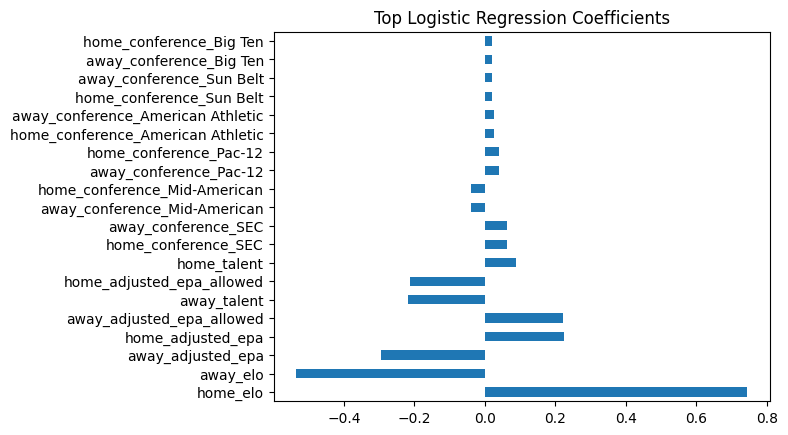

In [6]:
import pandas as pd

coef = model.named_steps['logisticregression'].coef_[0]
features = X_train.columns

importance = pd.Series(coef, index=features).sort_values(key=abs, ascending=False)

importance.head(20).plot(kind='barh', title="Top Logistic Regression Coefficients")

## 6. Calibration Curve

We will create a calibration curve as in previous notebooks to visualize how well the predicted probabilities match the actual outcomes.

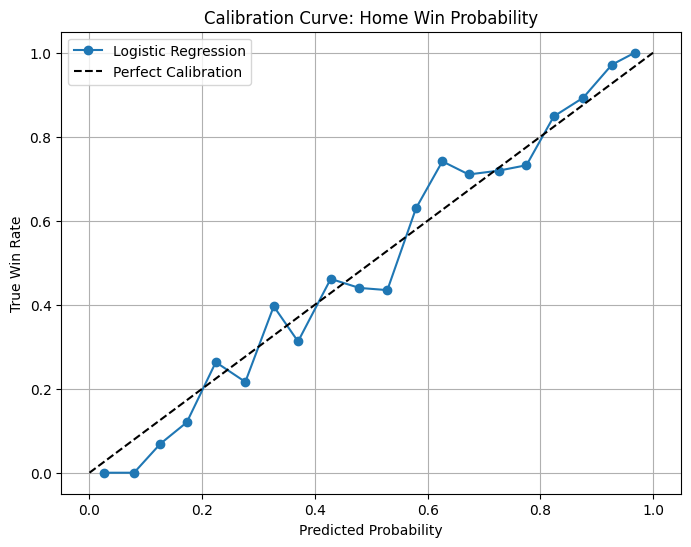

In [7]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=20)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Win Rate')
plt.title('Calibration Curve: Home Win Probability')
plt.legend()
plt.grid(True)
plt.show()

## 7. Save the Model

We will save the trained model using `joblib` as we have done in previous notebooks. This allows us to easily load the model later without needing to retrain it.

In [9]:
import joblib

joblib.dump(model, "logistic_regression_model.joblib")

['logistic_regression_model.joblib']

## 8. Next Steps
- **Hyperparameter Tuning:** Experiment with different hyperparameters like `C` (regularization strength) and `solver` (optimization algorithm) to improve model performance.
- **Feature Engineering:**
  Experiment with the features included in the training data. Add new features from the data and try different combinations to see if they improve the model's performance.
